# Taller de Machine Learning (Aprendizaje Automático)
</br>

### Edgar Zamora Durán
### DevOps Lead – Master Inventor @IBM
</br>

## Ejemplo de clasificacion
</br>

### Noviembre 2019

### 0. Importar librerias a utilizar

In [1]:
!pip install category-encoders

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import sklearn as skl
import imblearn 
from sklearn import preprocessing

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### 1. Instrucciones y parámetros a configurar


Se ha escogido el dataset [IBM HR Analytics Employee Attrition & Performance:
Predict attrition of your valuable employees](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) y se utilizará el archivo [WA_Fn-UseC_-HR-Employee-Attrition.csv](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset/downloads/ibm-hr-analytics-employee-attrition-performance.zip/1)  como fuente de datos.

Para poder ejecutar este notebook, se debe descargar el archivo .zip mencionado en el párrafo anterior, descomprimirlo y subir el .csv resultante dentro del directorio raíz de Collab, con las opciones  presentes en la pestaña "Files" o "Archivos".

**Importante:**

En las siguiente celda de codigo se deben establecer las configuraciones que se usaran para particionar y generar el conjunto de datos luego del preprocesamiento.
- problemDataSize: Tamano del dataset a asumir como problema de clasificacion. Debe ser un entero. El valor predeterminado es el tamano del dataset original luego de balancearlo.
- trainingSetPecentage: Porcentaje de datos del dataset a usar como set de entramiento. Numero entre 0 y 1.
- kSplits: Numero de folds para el set de entrenamiento entero. Debe establecerse en base an N. Como son pocos datos, el valor predetermiando es 5.

In [0]:
#Parametos
#Tamano del dataset a asumir como problema de clasificacion. Debe ser un entero. El valor predeterminado es el tamano del dataset original (1470, 237=Yes/1233=No) luego de balancearlo.
problemDataSize = 1470
#Porcentaje de datos del dataset a usar como set de entramiento. Numero entre 0 y 1.
trainingSetPercentage = 0.7
#Numero de folds para el set de entrenamiento entero. Debe establecerse en base a trainingSetPercentage. Como son pocos datos, el valor predetermiando es 5.
kSplits = 5

### 2. Contexto del conjunto de datos

Este es un dataset sintetico, cientificos de datos de IBM generaron datos ficticios basados en datos verdaderos originalmente publicados en este [blog](https://www.ibm.com/communities/analytics/watson-analytics-blog/hremployeeattrition/).

El proposito del mismo es poder estudiar y entender la rotacion de empleados. Desde un punto de vista estrategico para la orgaizacion es necesario minimizar este fenomeno, tal que se pueda atraer y retener el mejor talento, y tomar las acciones necesarias cuando se detecta que un buen empleado esta inconforme.

El dataset contiene informacion historica de empleados ficticios, incluyendo datos demograficos, satisfaccion con el trabajo, remuneracion, crecimiento en la empresa, y por supuesto el dato mas relevante: si la persona es un empleado actualmente o dejo el trabajo. 

El analisis de los datos permitira identificar los aspectos claves internos a la organizacion que motivan la rotacion de empleados. En manos de un equipo de recursos humanos podria ser muy util por los motivos explicados anteriormente.  

(*) Para los empleados que dejaron la compania se interpreta que los datos son los ultimos registrados por RRHH antes de su partida, para los empleados que aun laboran en la organizacion se interpreta que son datos actuales.

**Descripcion de las columnas:**

- Attrition: Es la variable objetivo. Es una variable categorica nominal con valores booleanos "Yes" y "No". Indica si la persona dejo la organizacion o no.

- Age: Es una variable numerica con valores entre 18 y 60. Indica la edad del empleado en anos.

- BusinessTravel: Es una variable categorica nominal con posibles valores "Non-travel", "Travel_Frecuently" y "Travel_Rarely".

- DailyRate: Es una variable numerica. Su unidad es Dolares (USD). Indica el pago diario plano (sin extras ni deducciones)  del empleado. 

- Department: Es una variable categorica nominal con posibles valores "Human Resources", "Research & Development" y "Sales".

- DistanceFromHome: Es una variable numerica. Su unidad es Kilometros (Kms). Indica la distancia entre el lugar de trabajo y el lugar d ehabitacon del empleado.

- Education: Es una variable categorica ordinal con valores numericos con el siguiente significado 1 = 'Below College', 2 = 'College', 3 = 'Bachelor',  4 = 'Master', 5 = 'Doctor'

- EducationField:  Es una variable categorica nominal con posibles valores	"Human Resources", "Medical", "Life Sciences", "Marketing", "Technical degree", "Other".

- EmployeeCount: No encontre referencias ni pude interpretar que significa, el valor siempre es 1, por lo que podria inferir es algun campo que retorno RRHH de su query para indicar que no hay agregaciones (cada fila coresponde  un empleado unico)

- EmployeeNumber: Es una variable numerica. Es diferente en cada fila. No encontre referencias ni pude interpretar que significa, por el formato no pareciera ser un id, al no ser continuo tampoco es un conteo incremental del numero de empleados del Manager que solicito el Dataset. Podria inferir que es un campo desde la base de datos que representa un conteo u orden pero por filtros en el query de RRHH ciertas filas no se retornaron

- EnvironmentSatisfaction	Es una variable categorica ordinal con valores 1 = "Low", 2 = "Medium", 3 =" High", 4 = "Very High". Es la mas reciente calificacion del empleado al ambiente de trabajo. 

- Gender	Es una variable categorica nominal con valores "Male" y "Female"

- HourlyRate: Es una variable numerica. Su unidad es Dolares (USD). Indica el pago por hora plano (sin extras ni deducciones)  del empleado. 

- JobInvolvement	Es una variable categorica ordinal con valores 1 = "Low", 2  = "Medium", 3 = "High" y  4 = "Very High". Metrica de compromiso y entusiasmo con el trabajo.

- JobLevel	Es una variable categorica ordinal con valores booleanos "1", "2", "3", "4" y "5". Representa categorias de autoridad en la organizacion, donde donde cada nivel esta tipicamente asociado con un rango de salarios salary, responsabilidades y titulos. Una posible categorizacion seria: executive management, middle management, management, advisors and employees.

- JobRole	Es una variable categorica nominal con valores posibles: "Sales Executive", "Research Scientist", "Laboratory Technician", "Research Scientist", "Manufacturing Director", "Healthcare Representative", "Manager", "Sales Representative", "Research Director".

- JobSatisfaction	Es una variable categorica ordinal con valores JobSatisfaction 1 = Low, 2 = Medium, 3 = High, 4 = Very High. Representa la calificacion mas resiente de satisfaccion del empleado con su trabajo.

- MaritalStatus	Es una variable categorica nominal con valores "Divorced", "Married" y "Single". Indica el estado conyugal del empleado.

- MonthlyIncome: Es una variable numerica. Su unidad son Dolares (USD). Indica el ingreso neto mensual del empleado.

- MonthlyRate: Es una variable numerica. Su unidad son Dolares (USD). Indica el pago por mes plano (sin extras ni deducciones)  del empleado. 

- NumCompaniesWorked: Es una variable numerica. Indica en cuantas companias ha trabajado el empleado.

- Over18:	Es una variable categorica nominal con valores booleanos "Y" y "N". Indica si el empleado es mayor de edad. Para este data set todas las filas tienen "Y" en este campo

- OverTime	Es una variable categorica nominal con valores booleanos "Yes" y "No". Indica si el empleado recibe pago por tiempo extra o no.

- PercentSalaryHike: Es una variable numerica. Es un procentaje que indica el incremento salarial del empleado. No pude encontrar o inferir si es un acumulado o el ultimo aumento que recibio el empleado.

- PerformanceRating: Es una variable categorica nominal con valores numericos 1 = "Low", 2 = "Good", 3 = "Excellent" y 4 = "Outstanding"


- RelationshipSatisfaction:	Es una variable categorica nominal con valores numericos 1 = "Low", 2 = "Medium", 3 = "High" y 4 = "Very High". Indica que tan satisfactoria es la relacion del empleado con la organizacion.

- StandardHours: Es una variable numerica. Su unidad son horas (hrs). Corresponde a la cantidad de horas a productivas a utilizar durante un periodo contable. Todal las filas tiene valor 80 para esta fila, por lo que se asume que el periodo contable son 2 semanas (40 horas por semana, jornada de 8 horas diarias).

- StockOptionLevel	Es una variable categorica nominal con valores numericos 1 = "Low", 2 = "Medium", 3 = "High" y 4 = "Very High". Indica la cantidad de acciones de la compania que el empleado puede comprar a precio preferencial en un lapso.

- TotalWorkingYears: Es una variable numerica. Su unidad son anos (yrs). Indica el numero de anos que el empleado ha trabajado en total.

- TrainingTimesLastYear: Es una variable numerica, un contador que indica la cantidad de entrenamientos formales que recibio el empleado el ultimo ano.

- WorkLifeBalance	Es una variable categorica nominal con valores numericos 1 = "Bad", 2 = "Good", 3 = "Better" y 4 = "Best"

- YearsAtCompany: Es una variable numerica. Su unidad son anos (yrs). Indica el numero de anos que el empleado ha trabajado en la organizacion.

- YearsInCurrentRoleEs una variable numerica. Su unidad son anos (yrs). Indica el numero de anos que el empleado ha trabajado en el mismo role.

- YearsSinceLastPromotion: Es una variable numerica. Su unidad son anos (yrs). Indica el numero de anos desde que el empleado recibio su ultima promocion.

- YearsWithCurrManager: Es una variable numerica. Su unidad son anos (yrs). Indica el numero de anos que el empleado ha ttenido el mismo jefe directo.


### 3. Carga de datos y análisis exploratorio

In [3]:
attrition_raw = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

attrition_raw.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [4]:
display(attrition_raw.isnull().any())

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

In [5]:
attrition_raw.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


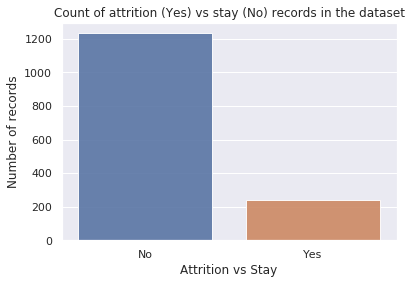

In [6]:
attrition_count = attrition_raw['Attrition'].value_counts()
sns.set(style="darkgrid")
sns.barplot(attrition_count.index, attrition_count.values, alpha=0.9)
plt.title('Count of attrition (Yes) vs stay (No) records in the dataset')
plt.ylabel('Number of records', fontsize=12)
plt.xlabel('Attrition vs Stay', fontsize=12)
plt.show()

### 4. Preprocesamiento

In [0]:
#Columnas a remover
#EmployeeCount: unique value (1)  
#EmployeeNumber: all values are distinct
#Over18: unique value (Yes)
#StandardHour: unique value (80)

bucketsColumns = ['Age', 'DistanceFromHome', 'DailyRate', 'HourlyRate', 
                  'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 
                  'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 
                  'YearsAtCompany', 'YearsInCurrentRole', 
                  'YearsSinceLastPromotion', 'YearsWithCurrManager']
categoricalBuckets = pd.DataFrame()
categoricalBuckets['Age'] = pd.cut(attrition_raw['Age'], [0, 18, 20, 30, 40, 50, 60, 70], right=False, labels=["0-17", "18-19", "20-29", "30-39", "40-49", "50-59", "60-69"])
categoricalBuckets['DistanceFromHome'] = pd.cut(attrition_raw['DistanceFromHome'], [0, 5, 10, 15, 20, 100], right=False, labels=["0-4", "5-9", "10-14", "15-19", "20-99"])
#Buckets needed to preprocess columns for the tree
categoricalBuckets['DailyRate'] = pd.cut(attrition_raw['DailyRate'], [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000], right=False, labels=["0-249", "250-499", "500-749", "750-999", "1000-1249", "1250-1499", "1500-1749", "1750-1999"])
categoricalBuckets['HourlyRate'] = pd.cut(attrition_raw['HourlyRate'], [0, 25, 50, 75, 100, 150], right=False, labels=["0-24", "25-49", "50-74", "75-99", "100-149"])
categoricalBuckets['MonthlyIncome'] = pd.cut(attrition_raw['MonthlyIncome'], [0, 5000, 10000, 15000, 20000, 25000], right=False, labels=["0-4999", "5000-9999", "10000-14999", "15000-19999", "20000-24999"])
categoricalBuckets['MonthlyRate'] = pd.cut(attrition_raw['MonthlyRate'], [0, 5000, 10000, 15000, 20000, 25000, 30000], right=False, labels=["0-4999", "5000-9999", "10000-14999", "15000-19999", "20000-24999", "25000-29999"])
categoricalBuckets['NumCompaniesWorked'] = pd.cut(attrition_raw['NumCompaniesWorked'], [0, 3, 6, 9, 12], right=False, labels=["0-3", "4-6", "7-9", "10-12"])
categoricalBuckets['PercentSalaryHike'] = pd.cut(attrition_raw['PercentSalaryHike'], [0, 5, 10, 15, 20, 25, 30], right=False, labels=["0-4", "5-9", "10-14", "15-19", "20-24", "25-29"])
categoricalBuckets['TotalWorkingYears'] = pd.cut(attrition_raw['TotalWorkingYears'], [0, 10, 20, 30, 40, 50], right=False, labels=["0-9", "10-19", "20-29", "30-39", "40-49"])
categoricalBuckets['TrainingTimesLastYear'] = pd.cut(attrition_raw['TrainingTimesLastYear'], [0, 3, 6, 9, 12], right=False, labels=["0-3", "4-6", "7-9", "10-12"])
categoricalBuckets['YearsAtCompany'] = pd.cut(attrition_raw['YearsAtCompany'], [0, 10, 20, 30, 40, 50], right=False, labels=["0-9", "10-19", "20-29", "30-39", "40-49"])
categoricalBuckets['YearsInCurrentRole'] = pd.cut(attrition_raw['YearsInCurrentRole'], [0, 5, 10, 15, 20, 25, 30], right=False, labels=["0-4", "5-9", "10-14", "15-19", "20-24", "25-29"])
categoricalBuckets['YearsSinceLastPromotion'] = pd.cut(attrition_raw['YearsSinceLastPromotion'], [0, 5, 10, 15, 20, 25, 30], right=False, labels=["0-4", "5-9", "10-14", "15-19", "20-24", "25-29"])
categoricalBuckets['YearsWithCurrManager'] = pd.cut(attrition_raw['YearsWithCurrManager'], [0, 5, 10, 15, 20, 25, 30], right=False, labels=["0-4", "5-9", "10-14", "15-19", "20-24", "25-29"])

categoricalColumns = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

categoricalBinaryColumns = ['OverTime']

categoricalOrdinalColumns = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement',  'JobLevel',
                             'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 
                             'WorkLifeBalance', 'StockOptionLevel']

targetColumn =['Attrition']
categorical = attrition_raw[categoricalColumns]
categoricalBinary = attrition_raw[categoricalBinaryColumns]
categoricalOrdinal = attrition_raw[categoricalOrdinalColumns]
target = attrition_raw[targetColumn]

In [8]:
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
categoricalOhe = ohe.fit_transform(categorical)
categoricalOhe.head()

,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,BusinessTravel_Non-Travel,Department_Sales,Department_Research & Development,Department_Human Resources,EducationField_Life Sciences,EducationField_Other,EducationField_Medical,EducationField_Marketing,EducationField_Technical Degree,EducationField_Human Resources,Gender_Female,Gender_Male,JobRole_Sales Executive,JobRole_Research Scientist,JobRole_Laboratory Technician,JobRole_Manufacturing Director,JobRole_Healthcare Representative,JobRole_Manager,JobRole_Sales Representative,JobRole_Research Director,JobRole_Human Resources,MaritalStatus_Single,MaritalStatus_Married,MaritalStatus_Divorced
0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
3,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


In [9]:
ohe2 = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
categoricalBucketsOhe = ohe2.fit_transform(categoricalBuckets)
categoricalBucketsOhe.head()

,Age_0-17,Age_18-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,DistanceFromHome_0-4,DistanceFromHome_5-9,DistanceFromHome_10-14,DistanceFromHome_15-19,DistanceFromHome_20-99,DailyRate_0-249,DailyRate_250-499,DailyRate_500-749,DailyRate_750-999,DailyRate_1000-1249,DailyRate_1250-1499,DailyRate_1500-1749,DailyRate_1750-1999,HourlyRate_0-24,HourlyRate_25-49,HourlyRate_50-74,HourlyRate_75-99,HourlyRate_100-149,MonthlyIncome_0-4999,MonthlyIncome_5000-9999,MonthlyIncome_10000-14999,MonthlyIncome_15000-19999,MonthlyIncome_20000-24999,MonthlyRate_0-4999,MonthlyRate_5000-9999,MonthlyRate_10000-14999,MonthlyRate_15000-19999,MonthlyRate_20000-24999,MonthlyRate_25000-29999,NumCompaniesWorked_0-3,NumCompaniesWorked_4-6,NumCompaniesWorked_7-9,NumCompaniesWorked_10-12,PercentSalaryHike_0-4,PercentSalaryHike_5-9,PercentSalaryHike_10-14,PercentSalaryHike_15-19,PercentSalaryHike_20-24,PercentSalaryHike_25-29,TotalWorkingYears_0-9,TotalWorkingYears_10-19,TotalWorkingYears_20-29,TotalWorkingYears_30-39,TotalWorkingYears_40-49,TrainingTimesLastYear_0-3,TrainingTimesLastYear_4-6,TrainingTimesLastYear_7-9,TrainingTimesLastYear_10-12,YearsAtCompany_0-9,YearsAtCompany_10-19,YearsAtCompany_20-29,YearsAtCompany_30-39,YearsAtCompany_40-49,YearsInCurrentRole_0-4,YearsInCurrentRole_5-9,YearsInCurrentRole_10-14,YearsInCurrentRole_15-19,YearsInCurrentRole_20-24,YearsInCurrentRole_25-29,YearsSinceLastPromotion_0-4,YearsSinceLastPromotion_5-9,YearsSinceLastPromotion_10-14,YearsSinceLastPromotion_15-19,YearsSinceLastPromotion_20-24,YearsSinceLastPromotion_25-29,YearsWithCurrManager_0-4,YearsWithCurrManager_5-9,YearsWithCurrManager_10-14,YearsWithCurrManager_15-19,YearsWithCurrManager_20-24,YearsWithCurrManager_25-29
0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [10]:
targetEncoded = target['Attrition'].replace(('Yes', 'No'), (1, 0), inplace=False)
targetEncoded = pd.DataFrame(targetEncoded, columns=['Attrition'])
targetEncoded.head()

,Attrition
0,1
1,0
2,1
3,0
4,0


In [11]:
categoricalBinaryEncoded = categoricalBinary['OverTime'].replace(('Yes', 'No'), (1, 0), inplace=False)
categoricalBinaryEncoded = pd.DataFrame(categoricalBinaryEncoded, columns=['OverTime'])
categoricalBinaryEncoded.head()

,OverTime
0,1
1,0
2,1
3,1
4,0


**Resumen de transformaciones por columna:**

- Columnas a remover
> - EmployeeCount: 
>>- **Justificacion**: Tiene un unico valor "1" en todas las filas.  
> - EmployeeNumber:
>>- **Justificacion**: Tiene valores distintos en todas las filas. 
> - Over18: unique value (Yes)
>>- **Justificacion**: Tiene un unico valor "Yes" en todas las filas. 
> - StandardHour: 
>>- **Justificacion**: Tiene un unico valor "80" en todas las filas. 


- One-Hot encoding
> - categoricalColumns = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
>>- **Justificacion**:  Las columnas tienen valores nominales sin orden, por lo que para asegurarnos de que los datos puedan ser procesados por distintos modelos se transforman a valores numericos con este encoding. 

- Buckets + One-Hot encoding
> - bucketsColumns = ['Age', 'DistanceFromHome', 'DailyRate', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
>>- **Justificacion**:  El bucketing se usa para agrupar todas las columnas numericas. Luego de hacer bucketing, las columnas tienen valores nominales sin orden, por lo que para asegurarnos de que los datos puedan ser procesados por distintos modelos se transforman a valores numericos con Onet-Hot encoding. 

- Codificacion a  1 (Yes) y 0 (No)
> - categoricalBinaryColumns = ['OverTime']
>>- **Justificacion**: Tiene solo valores "Yes" y "No". Se requiere una representacion numerica para que los datos sean aceptados por los diferentes modelos.
> - targetColumn =['Attrition']
>>- **Justificacion**: Tiene solo valores "Yes" y "No". Se requiere una representacion numerica para que los datos sean aceptados por los diferentes modelos.

- Ninguna transformacion:
> - categoricalOrdinalColumns = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement',  'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance', 'StockOptionLevel']
>>- **Justificacion**: Contienen valores numericos que representan un orden, se consideran ya procesados con una codificacion ordinal de acuerdo a la descripcion de los datos.

In [12]:
preprocessedAttrition = pd.concat([categoricalOhe, categoricalBucketsOhe, categoricalOrdinal, categoricalBinaryEncoded], axis=1)
print(preprocessedAttrition.shape)

(1470, 114)


In [13]:
from sklearn.model_selection import train_test_split

dataTrain, dataTest, targetTrain, targetTest = train_test_split(preprocessedAttrition, targetEncoded, train_size=trainingSetPercentage, random_state=0)

print(dataTrain.shape)
print(dataTest.shape)
print(targetTrain.shape)
print(targetTest.shape)

dataTrain.head(10)

(1029, 114)
(441, 114)
(1029, 1)
(441, 1)


,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,BusinessTravel_Non-Travel,Department_Sales,Department_Research & Development,Department_Human Resources,EducationField_Life Sciences,EducationField_Other,EducationField_Medical,EducationField_Marketing,EducationField_Technical Degree,EducationField_Human Resources,Gender_Female,Gender_Male,JobRole_Sales Executive,JobRole_Research Scientist,JobRole_Laboratory Technician,JobRole_Manufacturing Director,JobRole_Healthcare Representative,JobRole_Manager,JobRole_Sales Representative,JobRole_Research Director,JobRole_Human Resources,MaritalStatus_Single,MaritalStatus_Married,MaritalStatus_Divorced,Age_0-17,Age_18-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,DistanceFromHome_0-4,DistanceFromHome_5-9,DistanceFromHome_10-14,DistanceFromHome_15-19,DistanceFromHome_20-99,DailyRate_0-249,DailyRate_250-499,...,TotalWorkingYears_20-29,TotalWorkingYears_30-39,TotalWorkingYears_40-49,TrainingTimesLastYear_0-3,TrainingTimesLastYear_4-6,TrainingTimesLastYear_7-9,TrainingTimesLastYear_10-12,YearsAtCompany_0-9,YearsAtCompany_10-19,YearsAtCompany_20-29,YearsAtCompany_30-39,YearsAtCompany_40-49,YearsInCurrentRole_0-4,YearsInCurrentRole_5-9,YearsInCurrentRole_10-14,YearsInCurrentRole_15-19,YearsInCurrentRole_20-24,YearsInCurrentRole_25-29,YearsSinceLastPromotion_0-4,YearsSinceLastPromotion_5-9,YearsSinceLastPromotion_10-14,YearsSinceLastPromotion_15-19,YearsSinceLastPromotion_20-24,YearsSinceLastPromotion_25-29,YearsWithCurrManager_0-4,YearsWithCurrManager_5-9,YearsWithCurrManager_10-14,YearsWithCurrManager_15-19,YearsWithCurrManager_20-24,YearsWithCurrManager_25-29,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,WorkLifeBalance,StockOptionLevel,OverTime
338,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,4,2,2,3,3,3,3,3,0
363,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,4,3,1,3,3,2,3,0,1
759,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,4,2,3,1,2,3,1,3,0,0
793,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,1,3,1,3,3,4,2,1,0
581,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,4,1,1,3,4,3,3,2,0
320,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,4,3,2,3,3,1,3,0,1
452,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,3,4,3,2,2,3,2,4,1,0
195,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,3,2,4,1,1,3,1,2,1,1
776,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,4,3,1,4,3,2,3,0,1
1295,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,3,3,3,3,3,4,4,1,1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: DataConversionWarning: A column-vector y was passed whe

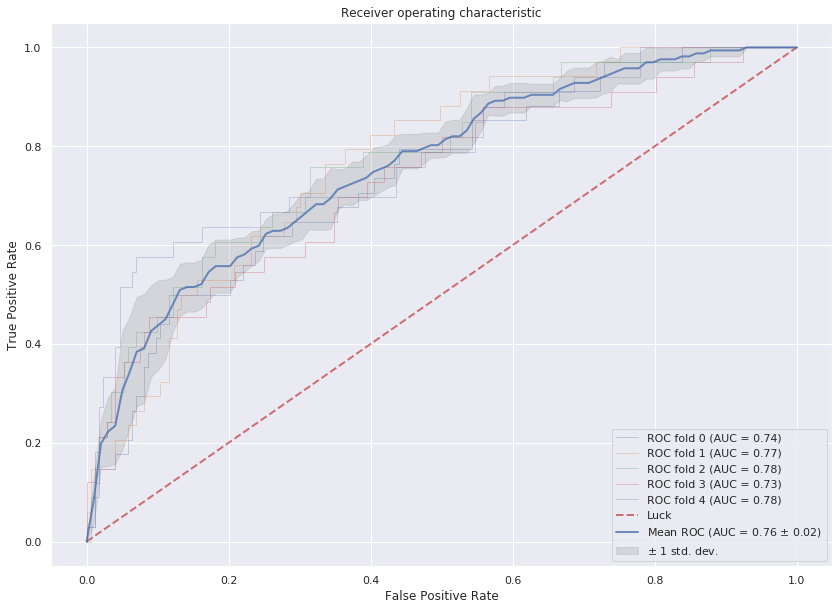

,AUC Train,AUC Test
0,0.929428,0.738354
1,0.936619,0.771506
2,0.932717,0.775370
3,0.913509,0.731501
4,0.921371,0.780832


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

#Size of the forrest
numberOfTrees = 20

clf = RandomForestClassifier(
    n_estimators=numberOfTrees,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(dataTrain.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(targetTrain.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


cv = StratifiedKFold(n_splits=kSplits, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(dataTrain, targetTrain), range(5)):
    clf.fit(dataTrain.iloc[train], targetTrain.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

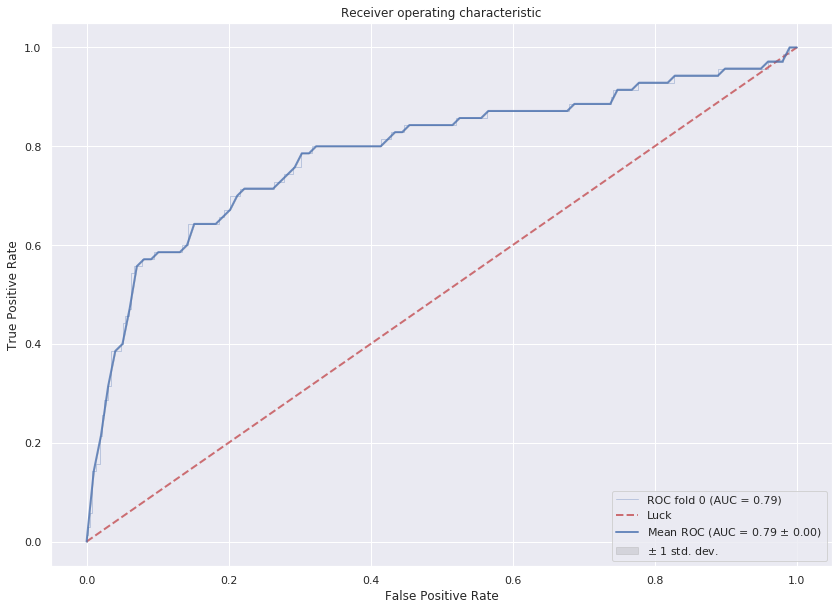

,AUC Validation
0,0.790874


In [15]:
fprs, tprs, scores = [], [], []

y_predict = clf.predict_proba(dataTest)[:,1]
fpr, tpr, thresholds = roc_curve(targetTest, y_predict)
auc_score = auc(fpr, tpr)

scores.append(auc_score)
fprs.append(fpr)
tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Validation'])